# Input Data

In [62]:
import pandas as pd
import torch
import numpy as np
import networkx as nx
import scipy.sparse as sp
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, from_scipy_sparse_matrix,dense_to_sparse,is_undirected

In [63]:
path = "hw2_data/"
dss = ['dataset1','dataset2','dataset3'] #datasets
dataset = dict()
for ds in dss:
    dataset[ds] = dict()
    dataset[ds]['content'] = pd.read_csv(path+ds+"/content.csv",delimiter = '\t',header = None)
    dataset[ds]['train'] = pd.read_csv(path+ds+"/train.csv",delimiter = ',')
    dataset[ds]['test'] = pd.read_csv(path+ds+"/test.csv",delimiter = ',')
    dataset[ds]['upload'] = pd.read_csv(path+ds+"/upload.csv",delimiter = ',')
dataset[dss[2]]['test'].head()

,id,to,from
0,E370,26,317
1,E667,196,323
2,E3190,739,468
3,E848,576,156
4,E2161,466,199


## Data Explore

In [64]:
print(dataset[dss[0]]['content'].shape)
print(len(dataset[dss[0]]['content']))
np.array(dataset[dss[0]]['content'].iloc[0,1:]).shape

(2708, 1434)
2708


(1433,)

In [65]:
print(dataset[dss[0]]['train'].shape)
print(len(dataset[dss[0]]['train']))
dataset[dss[0]]['train'].loc[1,'to']

(8686, 4)
8686


2397

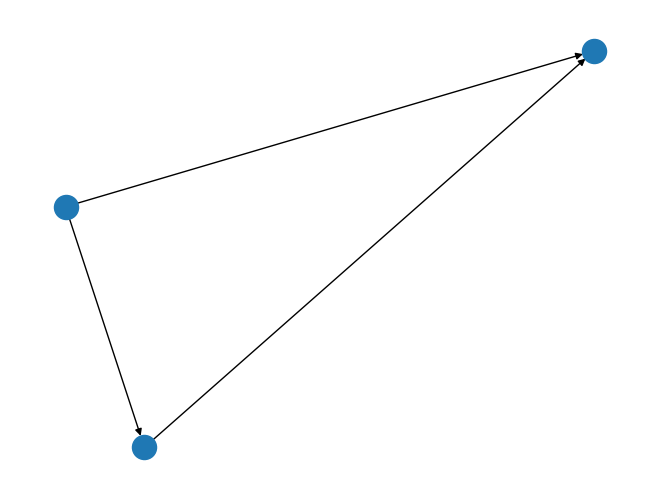

In [102]:
G = nx.DiGraph()
G.add_edge(0,1,label=0)
G.add_edge(0,2,label=1)
G.add_edge(1,2,label=1)
nx.draw(G)

In [103]:
[e for e in list(G.edges.data('label')) if e[2]==1]

[(0, 2, 1), (1, 2, 1)]

In [67]:
#For example:
Content = dataset[dss[0]]['content']
Train = dataset[dss[0]]['train']
Test = dataset[dss[0]]['test']

In [68]:
Content.shape

(2708, 1434)

In [69]:
Train[Train['label']==1]

,id,to,from,label
1,E10255,2397,1144,1
4,E5926,2450,1312,1
6,E7506,1808,2472,1
8,E7406,2030,2494,1
14,E10087,1767,4,1
...,...,...,...,...
8680,E1204,2508,2278,1
8682,E4741,1879,1443,1
8683,E9256,171,1711,1
8684,E4322,633,2440,1


---
# Main

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [71]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

## Data Preprocessing

In [72]:
def floor(x):
    return torch.div(x, 1, rounding_mode='trunc')

In [73]:
def preprocess_features(features):
    # Row-normalize feature matrix and convert to tuple representation
    # Because the datasets only have binary features, row-normalize is unnecessary
    rowsum = np.array(features.sum(1),dtype = np.float32)
    rowsum = (rowsum==0)*1+rowsum
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

In [158]:
def load_data(content,train,test):
    G = nx.DiGraph()
    G_test = nx.DiGraph()
    # for easier split the edges, create 2 graph, 1 with positive edge, the other with given negative edges
    G_pos = nx.DiGraph()
    G_neg = nx.DiGraph()
    graph_node_features_dict = dict()
    
    for i in range(len(content)):
        #graph_node_features_dict[content.iloc[i,0]] = np.array(content.iloc[i,1:])
        G.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        G_test.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        # pos and neg
        G_pos.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        G_neg.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        
    for i in range(len(train)):
        # Adding nodes into G
        '''
        if train.loc[i,'from'] not in G:
            G.add_node(train.loc[i,'from'],features = graph_node_features_dict[train.loc[i,'from']])
        if train.loc[i,'to'] not in G:
            G.add_node(train.loc[i,'to'],features = graph_node_features_dict[train.loc[i,'to']])
        ''' 
        # Adding edges
        G.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
        
        # pos and neg
        if train.loc[i,'label'] == 0: 
            G_neg.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
        else:
            G_pos.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
    
    for i in range(len(test)):
        # Adding edges
        G_test.add_edge(test.loc[i,'from'],test.loc[i,'to'])
    
    adj = nx.adjacency_matrix(G,sorted(G.nodes()))
    adj_test = nx.adjacency_matrix(G_test,sorted(G_test.nodes()))
    adj_pos = nx.adjacency_matrix(G_pos,sorted(G_pos.nodes()))
    adj_neg = nx.adjacency_matrix(G_neg,sorted(G_neg.nodes()))
    features = np.array(
        [features for _, features in sorted(G.nodes(data='features'), key=lambda x: x[0])])
    features = preprocess_features(features)
    
    # Skip train,valid,and test mask
    
    num_features = features.shape[1]
    features = torch.FloatTensor(features)
    return adj, adj_test, adj_pos, adj_neg, features, num_features

In [160]:
g, gtest, pos, neg, features, num_features = load_data(Content,Train,Test)

In [164]:
def split_edges(data):
    set_random_seed(10) #Seed is randomly set
    
    # ? This select the edges that from<to, but why?
    row, col = data.edge_index
    mask = row < col
    row, col = row[mask], col[mask]
    
    val_ratio = 0.1
    test_ratio = 0.1
    
    #split positive edges
    row_pos, col_pos = data.pos
    mask_pos = row_pos < col_pos
    row_pos, col_pos = row_pos[mask_pos], col_pos[mask_pos]
    
    
    n_v = floor(val_ratio * row_pos.size(0)).int() #number of validation positive edges
    n_t = floor(test_ratio * row_pos.size(0)).int() #number of test positive edges
    
    perm = torch.randperm(row_pos.size(0))
    row_pos, col_pos = row_pos[perm], col_pos[perm]
    r, c = row_pos[:n_v], col_pos[:n_v]
    data.val_pos = torch.stack([r, c], dim=0)
    r, c = row_pos[n_v:n_v+n_t], col_pos[n_v:n_v+n_t]
    data.test_pos = torch.stack([r, c], dim=0)
    r, c = row_pos[n_v+n_t:], col_pos[n_v+n_t:]
    data.train_pos = torch.stack([r, c], dim=0)
    print(data.train_pos.shape,data.test_pos.shape,data.val_pos.shape)

    #split neg edges
    row_neg, col_neg = data.neg
    mask_neg = row_neg < col_neg
    row_neg, col_neg = row_neg[mask_neg], col_neg[mask_neg]
    
    
    n_v = floor(val_ratio * row_neg.size(0)).int() #number of validation positive edges
    n_t = floor(test_ratio * row_neg.size(0)).int() #number of test positive edges
    
    perm = torch.randperm(row_neg.size(0))
    row_neg, col_neg = row_neg[perm], col_neg[perm]
    r, c = row_neg[:n_v], col_neg[:n_v]
    data.val_neg = torch.stack([r, c], dim=0)
    r, c = row_neg[n_v:n_v+n_t], col_neg[n_v:n_v+n_t]
    data.test_neg = torch.stack([r, c], dim=0)
    r, c = row_neg[n_v+n_t:], col_neg[n_v+n_t:]
    data.train_neg = torch.stack([r, c], dim=0)
    print(data.train_neg.shape,data.test_neg.shape,data.val_neg.shape)
    return data

    #costruct real test edges
    row_test,col_test = data.test
    data.test - torch.stack([row_test,col_test],dim = 0)
'''
    #sample negative edges
    if args.practical_neg_sample == False:
        # If practical_neg_sample == False, the sampled negative edges
        # in the training and validation set aware the test set

        neg_adj_mask = torch.ones(data.num_nodes, data.num_nodes, dtype=torch.uint8)
        neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
        neg_adj_mask[row, col] = 0

        # Sample all the negative edges and split into val, test, train negs
        neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
        perm = torch.randperm(neg_row.size(0))[:row.size(0)]
        neg_row, neg_col = neg_row[perm], neg_col[perm]

        row, col = neg_row[:n_v], neg_col[:n_v]
        data.val_neg = torch.stack([row, col], dim=0)

        row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
        data.test_neg = torch.stack([row, col], dim=0)

        row, col = neg_row[n_v + n_t:], neg_col[n_v + n_t:]
        data.train_neg = torch.stack([row, col], dim=0)

    else:

        neg_adj_mask = torch.ones(data.num_nodes, data.num_nodes, dtype=torch.uint8)
        neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
        neg_adj_mask[row, col] = 0

        # Sample the test negative edges first
        neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
        perm = torch.randperm(neg_row.size(0))[:n_t]
        neg_row, neg_col = neg_row[perm], neg_col[perm]
        data.test_neg = torch.stack([neg_row, neg_col], dim=0)

        # Sample the train and val negative edges with only knowing 
        # the train positive edges
        row, col = data.train_pos
        neg_adj_mask = torch.ones(data.num_nodes, data.num_nodes, dtype=torch.uint8)
        neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
        neg_adj_mask[row, col] = 0

        # Sample the train and validation negative edges
        neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()

        n_tot = n_v + data.train_pos.size(1)
        perm = torch.randperm(neg_row.size(0))[:n_tot]
        neg_row, neg_col = neg_row[perm], neg_col[perm]

        row, col = neg_row[:n_v], neg_col[:n_v]
        data.val_neg = torch.stack([row, col], dim=0)

        row, col = neg_row[n_v:], neg_col[n_v:]
        data.train_neg = torch.stack([row, col], dim=0)
    return data
'''
''''''

''

In [165]:
# Prepare the data
def prepare_data(content,train,test):
    g, gtest, pos, neg, features, num_features = load_data(content,train,test)
    A = g.toarray()
    edge_index,_ = dense_to_sparse(torch.tensor(A))
    Atest = gtest.toarray()
    edge_index_test,_ = dense_to_sparse(torch.tensor(Atest))
    Apos = pos.toarray()
    edge_index_pos,_ = dense_to_sparse(torch.tensor(Apos))
    Aneg = neg.toarray()
    edge_index_neg,_ = dense_to_sparse(torch.tensor(Aneg))
    data = Data(edge_index=edge_index,x=features.to(torch.float),pos = edge_index_pos,neg = edge_index_neg,test = edge_index_test)
    data = split_edges(data)
    return data

In [166]:
data = prepare_data(Content,Train,Test)
data.train_pos

torch.Size([2, 1729]) torch.Size([2, 216]) torch.Size([2, 216])
torch.Size([2, 1673]) torch.Size([2, 209]) torch.Size([2, 209])


tensor([[1067,  941,  304,  ...,   19, 1773, 1991],
        [1315, 2243,  360,  ...,  354, 2050, 2453]])

In [169]:
data.test.shape

torch.Size([2, 2172])

In [170]:
Test.shape

(2172, 3)

In [61]:
Train[Train['from']<Train['to']]

,id,to,from,label
0,E10311,2399,2339,0
1,E10255,2397,1144,1
3,E9395,872,702,0
4,E5926,2450,1312,1
9,E5573,682,100,0
...,...,...,...,...
8676,E1250,1481,611,1
8677,E0,1685,1150,1
8680,E1204,2508,2278,1
8681,E1171,1643,1383,0


In [ ]:
    #load data from .mat or download from Planetoid dataset.
    
    if args.data_name in ('cora', 'citeseer', 'pubmed'):
        data = load_Planetoid_data(args)
        data = split_edges(data,args)
    elif args.data_name in ('chameleon','squirrel','film','cornell','texas','wisconsin'):
        datastr = args.data_name
        split_index=str(0)## this split is node-classification split from geom-gcn, not for link prediction
        splitstr = 'data/new_data_splits/'+datastr+'_split_0.6_0.2_'+split_index+'.npz'
        g, features, labels, _, _, _, num_features, num_labels = new_load_data(datastr,splitstr)
        A=g.toarray()
        edge_index,_=dense_to_sparse(torch.tensor(A))
        data=Data(edge_index=edge_index,x=features.to(torch.float))
        data = split_edges(data,args)
    else:
        if args.use_splitted == True: #use splitted train/val/test
            data = load_splitted_data(args)
        else:
            data = load_unsplitted_data(args)
            data = split_edges(data,args)
    
    

    set_random_seed(args.seed)
    data_observed,feature_results= set_init_attribute_representation(data,args)

    #Construct train, val and test data loader.
    set_random_seed(args.seed)
    train_graphs = []
    val_graphs = []
    test_graphs = []
    for i in range(data.train_pos.size(1)):
        train_graphs.append(minus_edge(data_observed,1,data.train_pos[:,i],args))

    for i in range(data.train_neg.size(1)):
        train_graphs.append(plus_edge(data_observed,0,data.train_neg[:,i],args))

    for i in range(data.test_pos.size(1)):
        test_graphs.append(plus_edge(data_observed,1,data.test_pos[:,i],args))

    for i in range(data.test_neg.size(1)):
        test_graphs.append(plus_edge(data_observed,0,data.test_neg[:,i],args))   
    if args.observe_val_and_injection == False:
        for i in range(data.val_pos.size(1)):
            val_graphs.append(plus_edge(data_observed,1,data.val_pos[:,i],args))

        for i in range(data.val_neg.size(1)):
            val_graphs.append(plus_edge(data_observed,0,data.val_neg[:,i],args))
    else:
        for i in range(data.val_pos.size(1)):
            val_graphs.append(minus_edge(data_observed,1,data.val_pos[:,i],args))

        for i in range(data.val_neg.size(1)):
            val_graphs.append(plus_edge(data_observed,0,data.val_neg[:,i],args))


    
    print('Train_link:', str(len(train_graphs)),' Val_link:',str(len(val_graphs)),' Test_link:',str(len(test_graphs)))

    train_loader = DataLoader(train_graphs,batch_size=args.batch_size,shuffle=True)
    val_loader = DataLoader(val_graphs,batch_size=args.batch_size,shuffle=True)
    test_loader = DataLoader(test_graphs,batch_size=args.batch_size,shuffle=False)

    return train_loader, val_loader, test_loader,feature_results
